<a href="https://colab.research.google.com/github/UsamaK98/SemesterProject_NLP/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis**
## Usama Khatab (19i-0493)
## Chaudhry Ammar (19i-0678)

In [1]:
!pip install torchtext==0.6.0
!pip install transformers>=4.0.0
!pip install torch>=1.8.0
!pip install wordcloud 
#pip install torch==1.8.0+cu110 torchvision==0.9.0+cu110 torchaudio===0.8.0 -f https://download.pytorch.org/whl/cu110/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Replace this with the path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/reviews_0_250.csv'

# Read the CSV file using pandas
df1 = pd.read_csv(file_path)

<ipython-input-3-7986151f8555>:7: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(file_path)


In [42]:
#Some additional preprocessing steps
df = df1[:5000]

missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Unnamed: 0                     0
author_id                      0
rating                         0
is_recommended                 0
helpfulness                  989
total_feedback_count           0
total_neg_feedback_count       0
total_pos_feedback_count       0
submission_time                0
review_text                    0
review_title                1471
skin_tone                    337
eye_color                    355
skin_type                    212
hair_color                   450
product_id                     0
product_name                   0
brand_name                     0
price_usd                      0
dtype: int64


In [33]:
duplicates = df.duplicated(subset=['review_text']).sum()
print("Number of duplicated rows:", duplicates)


Number of duplicated rows: 8


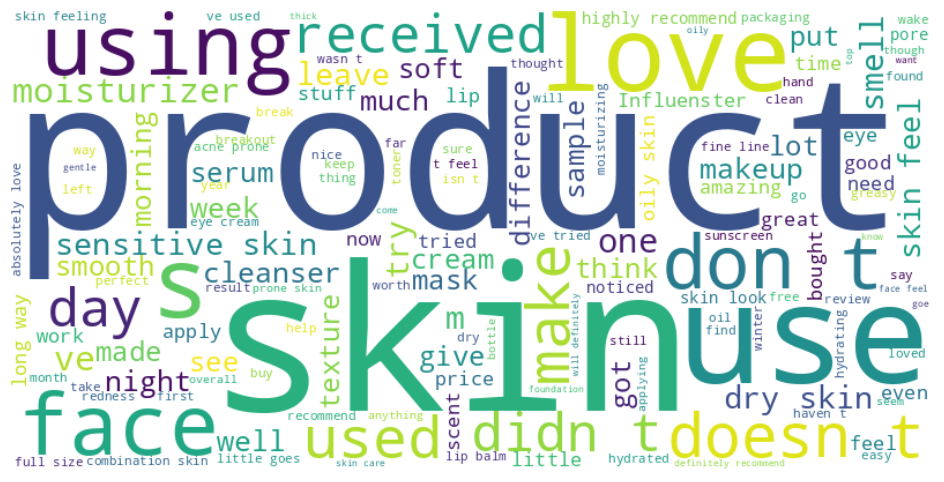

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd

# Extract the "review_text" column from the data frame
review_text = df1['review_text'].astype(str)

# Define stopwords to be excluded from the word cloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href", "don t", "didn t", ])  # Add any other stopwords you'd like to exclude

# Create a word cloud
word_cloud = WordCloud(stopwords=stopwords,
                       max_words=150,
                       background_color='white',
                       colormap='viridis',  # Change the color scheme
                       width=800,
                       height=400).generate(' '.join(review_text))

# Display the generated word cloud
plt.figure(figsize=(12, 6))  # Modify the figure size
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [43]:
import pandas as pd
import torch
import torchtext
import torchtext.data as data
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertTokenizer

# Create sentiment labels based on rating
def create_sentiment_label(rating):
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Filter relevant columns and create sentiment labels
df = df[['rating', 'review_text']]
df['sentiment'] = df['rating'].apply(create_sentiment_label)

# Save the preprocessed data to new CSV files
df = df[['review_text', 'sentiment']]
df.sample(frac=1).reset_index(drop=True)  # Shuffle the data
train_data, valid_data = train_test_split(df, test_size=0.2, random_state=42)

train_data.to_csv("train.csv", index=False)
valid_data.to_csv("valid.csv", index=False)


<ipython-input-43-6d69ec56d7f0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['rating'].apply(create_sentiment_label)


Class distribution:
 2    3765
0     808
1     427
Name: sentiment, dtype: int64


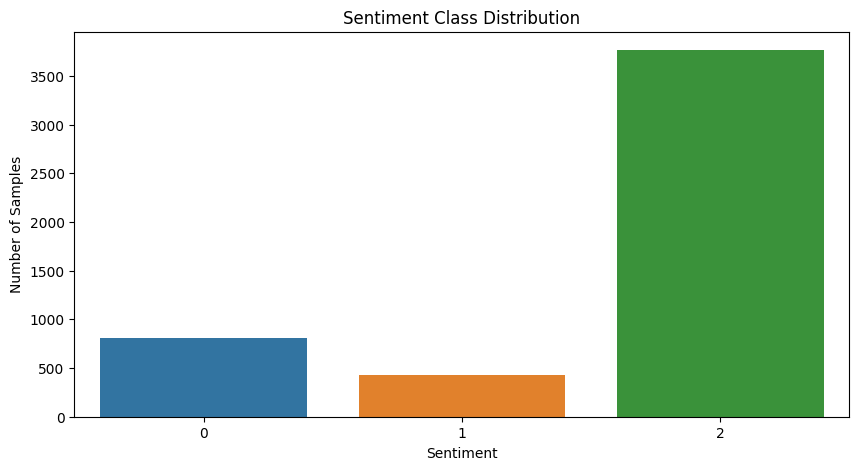

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['sentiment'].value_counts()
print("Class distribution:\n", class_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Samples")
plt.show()


In [50]:

# Read the CSV file
#df = pd.read_csv("C:/Users/ammar/Downloads/archive/reviews_0_250.csv")

#limiting the dataset for faster training - >>>>> REMOVE THIS <<<<<
#df = df1[:500]

#df = df1[:5000]

# Tokenizer setup
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

max_input_length = tokenizer.max_model_input_sizes['distilbert-base-multilingual-cased']

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length - 2]
    return tokens

# Define torchtext Fields
TEXT = data.Field(batch_first=True,
                  use_vocab=False,
                  tokenize=tokenize_and_cut,
                  preprocessing=tokenizer.convert_tokens_to_ids,
                  init_token=init_token_idx,
                  eos_token=eos_token_idx,
                  pad_token=pad_token_idx,
                  unk_token=unk_token_idx)

LABEL = data.LabelField(dtype=torch.float)

# Create Dataset
fields = [('text', TEXT), ('label', LABEL)]
train_data, valid_data = data.TabularDataset.splits(
    path='',
    train='train.csv',
    validation='valid.csv',
    format='csv',
    fields=fields,
    skip_header=True
)

# Build the vocabulary for the LABEL field
LABEL.build_vocab(train_data)

# Set up DataLoader
BATCH_SIZE = 16

if torch.cuda.is_available():
    print("GPU is available. Device:", torch.cuda.get_device_name(0))
    device = torch.device('cuda:0')
else:
    print("Using CPU.")
    device = torch.device('cpu')


train_iterator, valid_iterator = torchtext.data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True
)

# Load the model and set it up for training
model = DistilBertForSequenceClassification.from_pretrained(
    'philschmid/distilbert-base-multilingual-cased-sentiment-2',
    num_labels=len(LABEL.vocab)
)

model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-6, weight_decay=3e-3)
criterion = torch.nn.CrossEntropyLoss()

# Training and validation functions
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)[0]
        loss = criterion(predictions, batch.label.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)[0]
            loss = criterion(predictions, batch.label.long())
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Train the model
NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}')

       


GPU is available. Device: Tesla T4
Epoch 1, Train Loss: 3.9682, Val Loss: 4.0789
Epoch 2, Train Loss: 3.9706, Val Loss: 4.0651
Epoch 3, Train Loss: 3.9523, Val Loss: 4.0514
Epoch 4, Train Loss: 3.9502, Val Loss: 4.0376
Epoch 5, Train Loss: 3.9297, Val Loss: 4.0237
Epoch 6, Train Loss: 3.9200, Val Loss: 4.0098
Epoch 7, Train Loss: 3.9019, Val Loss: 3.9959
Epoch 8, Train Loss: 3.8752, Val Loss: 3.9820
Epoch 9, Train Loss: 3.8672, Val Loss: 3.9678
Epoch 10, Train Loss: 3.8491, Val Loss: 3.9537
Epoch 11, Train Loss: 3.8281, Val Loss: 3.9395
Epoch 12, Train Loss: 3.8367, Val Loss: 3.9252
Epoch 13, Train Loss: 3.8005, Val Loss: 3.9109
Epoch 14, Train Loss: 3.7948, Val Loss: 3.8965
Epoch 15, Train Loss: 3.7827, Val Loss: 3.8820
Epoch 16, Train Loss: 3.7663, Val Loss: 3.8676
Epoch 17, Train Loss: 3.7484, Val Loss: 3.8531
Epoch 18, Train Loss: 3.7451, Val Loss: 3.8387
Epoch 19, Train Loss: 3.7371, Val Loss: 3.8242
Epoch 20, Train Loss: 3.7158, Val Loss: 3.8097
Epoch 21, Train Loss: 3.6898, Val 

In [51]:
#SIMPLIFIED PREDITOR
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length - 2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.argmax(model(tensor)[0], dim=1)
    return prediction.item()

# Example usage
example_review = "This lip balm is the best I ever had. It works. It hydrates and last long. It has everything you need in a balm. It even has a little spatula that you can use to scoop the product easily and cleanly."
sentiment = predict_sentiment(model, tokenizer, example_review)

sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
print(f'Sentiment: {sentiment_mapping[sentiment]}')


Sentiment: Positive


In [54]:
#RAW SCORE PREDICTOR (Probability) FOR EACH CLASS
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length - 2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    logits = model(tensor)[0]
    probabilities = torch.softmax(logits, dim=1)
    prediction = torch.argmax(logits, dim=1)
    return prediction.item(), probabilities.squeeze().tolist()

# Example usage
example_review = "I dont like this product!"
sentiment, sentiment_probabilities = predict_sentiment(model, tokenizer, example_review)

sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
print(f'Sentiment: {sentiment_mapping[sentiment]}')
print(f'Probabilities: {sentiment_probabilities}')


Sentiment: Negative
Probabilities: [0.7286331057548523, 0.19963088631629944, 0.07173599302768707]
